# Bandit Problems

Given $k$ options, which option is the best?

For option $i$, receive $r_i \sim B_i$

Want to get to the optimal policy ASAP


---



# Exploration vs Exploitation

![alt](https://img.memecdn.com/guild-wars-2-the-gift-of-exploration_o_1137524.jpg)

## Need to understand the reward from each option, under constraints of minimizing regret

---

# $\epsilon$-Greedy algorithms

Simple way to trade off between explore and exploit

With probability $1-\epsilon$, do the best action based on what you know

With probability $\epsilon$, do a random action

In [32]:
import warnings
warnings.filterwarnings('ignore')
import gym_bandits
import gym
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_context('talk')
sns.set_palette('colorblind')

To understand the ideas behind bandits, we're going to play with [gym-bandit's 10-armed Gaussian Bandit](https://github.com/JKCooper2/gym-bandits)  

Each bandit has a Normal Distributed reward with a given mean and standard deviation

We'll show each distribution with `env.r_dist`

In [33]:
env = gym.make("BanditTenArmedGaussian-v0")

[2017-05-20 14:12:28,868] Making new env: BanditTenArmedGaussian-v0


In [34]:
env.r_dist

[[-0.16988640904391208, 1],
 [0.6416673033941586, 1],
 [-0.47677705405343845, 1],
 [0.2678975750437776, 1],
 [-0.6944707317745418, 1],
 [-1.6756184514926822, 1],
 [0.6291422518626523, 1],
 [0.7826573491682057, 1],
 [1.401923557496014, 1],
 [0.14201783585391056, 1]]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

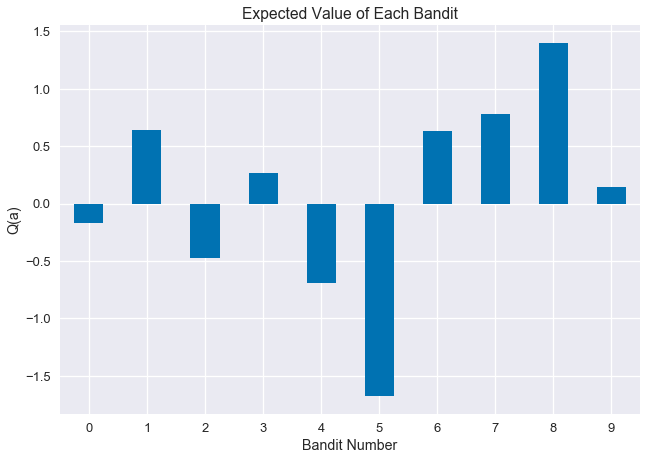

In [35]:
bandit_means = pd.Series([b[0] for b in env.r_dist])
bandit_means.plot(kind='bar')
plt.title('Expected Value of Each Bandit')
plt.ylabel('Q(a)')
plt.xlabel('Bandit Number')
plt.xticks(rotation=0)

Which bandit should we pick?

In [36]:
bandit_means.idxmax()

8

We'll first use a simple stochastic policy with a fixed epsilon $\epsilon = .1$

In [37]:
iterations = 1000
epsilon = .1
policy = env.action_space.sample()
bandit_data = pd.DataFrame(index=(range(iterations)), columns=['arm', 'reward', 'epsilon',
                                                               'regret', 'policy', 'random_policy'])
bandit_data['reward'] = bandit_data['reward'].astype('float')

In [38]:
for i in range(iterations):
    if bool(np.random.binomial(1, epsilon)):
        arm = env.action_space.sample()
    else:
        arm = policy
    reward = env.step(arm)[1]
    regret = i*bandit_means.max() - bandit_data['reward'].ix[:i].sum()
    bandit_data.ix[i] = pd.Series(data=[arm, reward, epsilon, regret, policy, arm != policy], index=list(bandit_data.columns))
    policy = int(bandit_data.ix[:i].groupby('arm')['reward'].mean().idxmax())

In [39]:
bandit_data.tail()

,arm,reward,epsilon,regret,policy,random_policy
995,8,1.619765,0.1,142.042,8,False
996,8,0.840115,0.1,141.824,8,False
997,8,0.424666,0.1,142.386,8,False
998,8,1.582270,0.1,143.363,8,False
999,8,3.468685,0.1,143.182,8,False


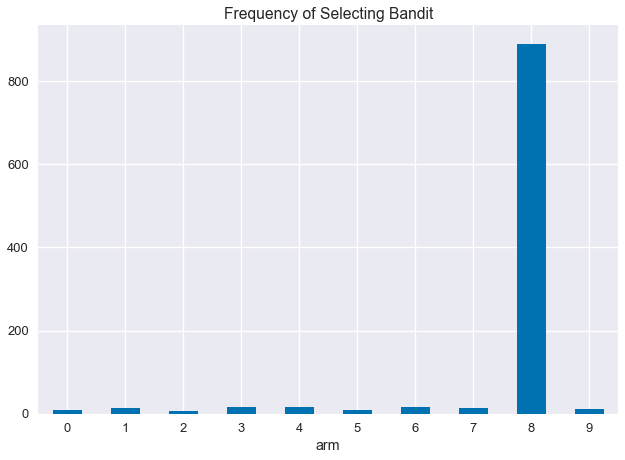

In [40]:
arm_counts = bandit_data.groupby('arm')['epsilon'].count()
arm_counts.index = arm_counts.index.astype(int)
ax = arm_counts.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Frequency of Selecting Bandit')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

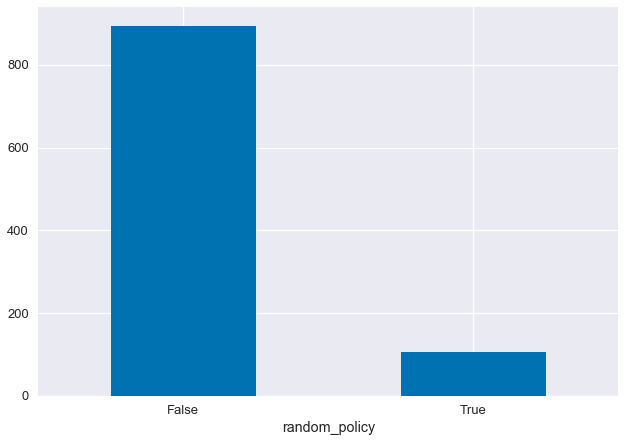

In [41]:
bandit_data.groupby('random_policy')['epsilon'].count().plot(kind='bar')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

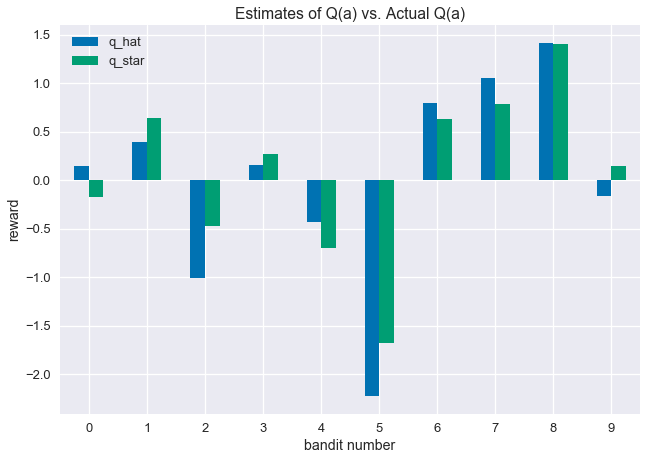

In [42]:
v_values = pd.DataFrame(bandit_data.groupby('arm')['reward'].mean()).join(pd.DataFrame(bandit_means), how='outer')
v_values.columns = ['q_hat', 'q_star']
v_values.plot(kind='bar')
plt.title('Estimates of Q(a) vs. Actual Q(a)')
plt.xlabel('bandit number')
plt.ylabel('reward')
plt.xticks(rotation=0)

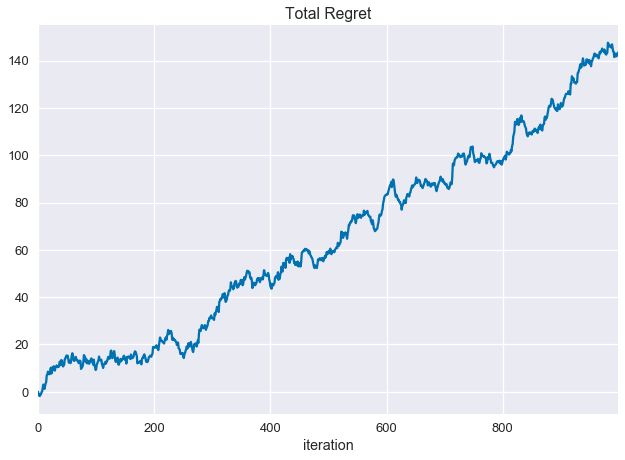

In [43]:
bandit_data['regret'].plot()
plt.title('Total Regret')
plt.xlabel('iteration')

## Theorhetically, regret with $\epsilon$-greedy grows linerally

This is because even if we know which bandit is best, we'll pick the wrong bandit with probability $\epsilon$

To get sublinear regret, we want to converge greedy policy

We can instead tune down $\epsilon$ to more consistently use our greedy polciy 

In [44]:
iterations = 1000
epsilon = .1
policy = env.action_space.sample()
old_regret = bandit_data['regret']
bandit_data = pd.DataFrame(index=(range(iterations)), columns=['arm', 'reward', 'epsilon', 'regret', 'policy', 'random_policy'])
bandit_data['reward'] = bandit_data['reward'].astype('float')

for i in range(iterations):
    if bool(np.random.binomial(1, epsilon)):
        arm = env.action_space.sample()
    else:
        arm = policy
    reward = env.step(arm)[1]
    regret = i*bandit_means.max() - bandit_data['reward'].ix[:i].sum()
    bandit_data.ix[i] = pd.Series(data=[arm, reward, epsilon, regret, policy, arm != policy], index=list(bandit_data.columns))
    policy = int(bandit_data.ix[:i].groupby('arm')['reward'].mean().idxmax())
    epsilon = 1./((i/50) + 10)

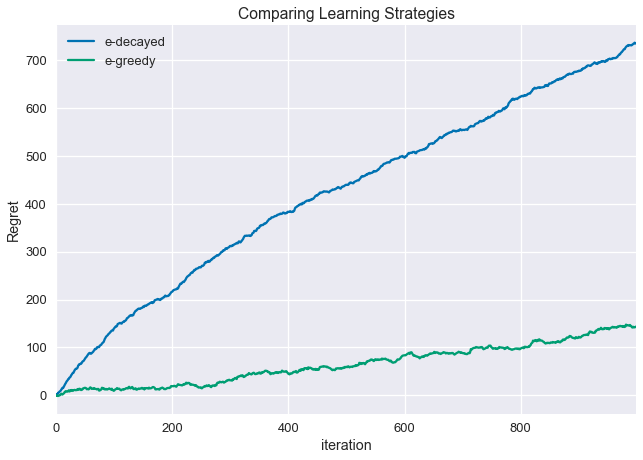

In [45]:
regret_comp = pd.DataFrame(bandit_data['regret']).join(pd.DataFrame(old_regret), lsuffix='new', rsuffix='old')
regret_comp.columns = ['e-decayed', 'e-greedy']
regret_comp.plot()
plt.title('Comparing Learning Strategies')
plt.ylabel('Regret')
plt.xlabel('iteration')

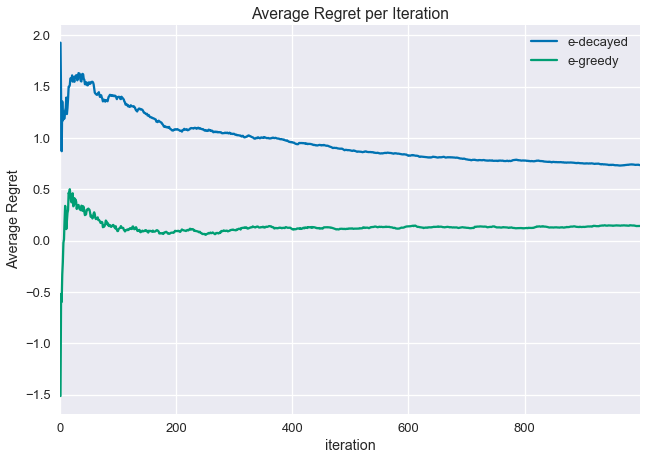

In [46]:
pd.DataFrame([np.divide(regret_comp['e-decayed'],regret_comp.index),
              np.divide(regret_comp['e-greedy'],regret_comp.index)]).T.plot()
plt.title('Average Regret per Iteration')
plt.xlabel('iteration')
plt.ylabel('Average Regret')